## Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data for handwriting recognition:
    * PCA
    * Autoencoders
2. Use appropriate scoring metrics to compare the performance of each.


## MNIST data

Throughout, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01), which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.16.1


## Importing Required Libraries


In [2]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();

### Preprocess MNIST


We'll preprocess by scaling images pixels to be between 0 and 1.


In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Part 1: PCA


We'll use PCA as a baseline with which we can compare our deep learning models.


For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:


In [5]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


PCA works better if our features are scaled, so let's do that. 


In [6]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [7]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [8]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


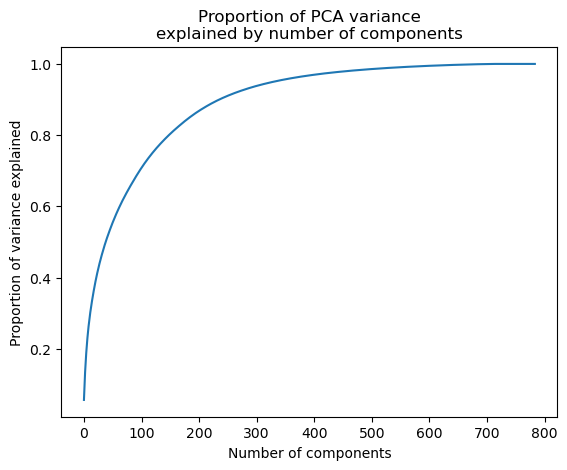

In [9]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We need about 250 components to explain 90% of the variance in the data!


### Scoring PCA


What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

As with all models, we should test performance on a different dataset than we trained on:


In [10]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.6


In [11]:
s = StandardScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)

In [12]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [13]:
x_test_reconstructed_64.shape

(10000, 784)

In [14]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(true, reconstructed)

0.31624043

Average MSE of **0.31**, using 64 components, for PCA.


### Simple AE


Now let's build an autoencoder! Fundamentally, an autoencoder is an neural network where the input is the same as the output. The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.


In [16]:
from keras.layers import Input, Dense
from keras.models import Model

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* The "full autoencoder", here `full_model`, will take inputs and try to reconstruct them
* The "encoder", here `encoder_model`, will take inputs and try to reconstruct them
* The "decoder", here `decoder_model`, will take the latent space and try to reconstruct it


In [17]:
ENCODING_DIM = 64

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [18]:
full_model.summary()

Model: "full_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [20]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0110 - loss: 0.3028


In [21]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


(10000, 64)

In [22]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mean_squared_error(decoded_images, x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


0.06573498

Significantly better than PCA!

Let us now add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.


In [23]:
ENCODING_DIM = 64
HIDDEN_DIM = 256

# Encoder model
inputs = Input(shape=(784,)) 
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(inputs)
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [24]:
full_model.summary()

Model: "full_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       217,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       218,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,536 (1.66 MB)

 Trainable params: 435,536 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [25]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [26]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0095 - loss: 0.2419
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0113 - loss: 0.1407


In [27]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mean_squared_error(decoded_images, x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


0.01855047

Our AE model has improved compared to PCA!